<img src="images/openfood.png" alt="https://medium.com/@agarwal.vishal819/outlier-detection-with-boxplots-1b6757fafa21">

L'agence **"Santé publique France"** a lancé un appel à projets pour trouver des idées innovantes d’applications en lien avec l'alimentation. Vous souhaitez y participer et proposer une idée d’application.



**Les données**

Extrait de l'appel à projets :

Le jeu de données **Open Food Fact** est disponible sur le site officiel https://world.openfoodfacts.org/. Les variables sont définies à cette adresse https://world.openfoodfacts.org/data/data-fields.txt

Les champs sont séparés en quatre sections :

* Les informations générales sur la fiche du produit : nom, date de modification, etc.
* Un ensemble de tags : catégorie du produit, localisation, origine, etc.
* Les ingrédients composant les produits et leurs additifs éventuels.
* Des informations nutritionnelles : quantité en grammes d’un nutriment pour 100 grammes du produit.

**Votre mission**

Après avoir lu l’appel à projets, voici les différentes étapes que vous avez identifiées :

1) Traiter le jeu de données afin de repérer des variables pertinentes pour les traitements à venir. Automatiser ces traitements pour éviter de répéter ces opérations.
(**Le programme doit fonctionner si la base de données est légèrement modifiée (ajout d’entrées, par exemple).**)

2) Tout au long de l’analyse, produire des visualisations afin de mieux comprendre les données. Effectuer une analyse univariée pour chaque variable intéressante, afin de synthétiser son comportement.
(**L’appel à projets spécifie que l’analyse doit être simple à comprendre pour un public néophyte. Soyez donc attentif à la lisibilité : taille des textes, choix des couleurs, netteté suffisante, et variez les graphiques (boxplots, histogrammes, diagrammes circulaires, nuages de points…) pour illustrer au mieux votre propos.**)

3) Élaborer une idée d’application. Identifier des arguments justifiant la faisabilité (ou non) de l’application à partir des données Open Food Facts.

## Documents 

* Graphique : https://www.psiweb.org/docs/default-source/2018-psi-conference-posters/48-julie-jones.pdf
* Missingno : https://github.com/ResidentMario/missingno

## Cours

* Décrivez et nettoyez votre jeu de données : https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees

* Réalisez une analyse exploratoire de données : https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-exploratoire-de-donnees

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import decomposition
from sklearn import preprocessing

In [3]:
df = pd.read_csv('data/nutri_score.csv', sep='\t', low_memory=False)

In [4]:
print(f"Le dataset 'Nutriscore' comporte {df.shape[0]} lignes et {df.shape[1]} colonnes")

Le dataset 'Nutriscore' comporte 2033614 lignes et 187 colonnes


In [5]:
df.isna().sum()

code                        0
url                         0
creator                     4
created_t                   0
created_datetime            0
                       ...   
choline_100g          2033543
phylloquinone_100g    2031902
beta-glucan_100g      2033575
inositol_100g         2033541
carnitine_100g        2033572
Length: 187, dtype: int64

<span style="color:#d95cdb">On remarque que les données sont très volumineuses. Il est donc important de faire attention à la taille des données et de les nettoyer.
Pour commencer, on peut voir ci-dessus que certaines colonnes sont inutiles dues à un trop grand nombre de données manquantes.</span>

In [6]:
PERCENTAGE_NA_MAX = 40  # Pourcentage de NA maximum autorisé
df_clear = df.copy()
list_col_to_keep = ['nutrition-score-fr_100g', 'nutriscore_grade', 'nutriscore_score']

percentage_na = 100 * df_clear.isna().sum() / df_clear.shape[0] # Calcul du pourcentage de NA pour chaque colonne
df_clear = df_clear.loc[:, (percentage_na <= PERCENTAGE_NA_MAX) | (df_clear.columns.isin(list_col_to_keep))] # Suppression des colonnes avec trop de NA

df_clear['rows_empty'] = df_clear.isna().sum(axis=1) / df_clear.shape[1]*100
df_clear = df_clear.loc[df_clear['rows_empty'] <= PERCENTAGE_NA_MAX] # Suppression des lignes avec trop de NA


In [7]:
df_clear.shape

(1894051, 31)

<span style="color:#d95cdb">Après le nettoyage des colonnes, il ne nous reste plus que 56 colonnes utilisables.
Nous allons maintenant réduire nos nombres de lignes afin d'avoir un jeu de données le plus pertinant possible.</span>

In [8]:
df_clear['countries_tags'].value_counts()

en:france                                                                                        736419
en:united-states                                                                                 370606
en:spain                                                                                         209800
en:italy                                                                                         114655
en:germany                                                                                        72247
                                                                                                  ...  
en:france,en:germany,en:poland,en:switzerland,en:united-kingdom                                       1
en:francia-spain                                                                                      1
en:algeria,en:belgium,en:france,en:poland,en:portugal,en:united-kingdom                               1
en:bulgaria,en:czech-republic,en:hungary,en:poland,en:romania,en

In [9]:
df_clear = df_clear.dropna(subset=['countries_tags'])
fr_tags = df_clear['countries_tags'].str.split(',')

df_french_data = df_clear.loc[fr_tags.str.contains('en:france', regex=False)]

print(f"df_french : {df_french_data.shape} et data_clear : {df_clear.shape}")

df_french : (806587, 31) et data_clear : (1891444, 31)


<span style="color:#d95cdb">Au vu de l'objectif de création d'un jeu de données pour une application française, nous décidons de ne garder que les produits vendues sur le territoire français.</span>

<span style="color:#d95cdb">Nous allons maintenant supprimer les duplications de lignes et corriger les outliners.</span>

In [10]:
df_french_data.duplicated('code').sum()
list_duplicate = df_french_data.loc[df_french_data.duplicated('code', keep=False) == True]
df_french_data = df_french_data.drop_duplicates('code')

In [11]:
df_french_data = df_french_data.drop_duplicates('code')

In [12]:
df_french_data.describe()

,created_t,last_modified_t,nutriscore_score,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,rows_empty
count,8.065820e+05,8.065820e+05,308726.000000,6.347630e+05,6.604690e+05,654608.000000,658417.000000,654559.000000,658043.000000,656431.000000,636427.000000,636426.000000,308729.000000,806582.000000
mean,1.542844e+09,1.590509e+09,9.433349,2.795625e+02,1.168862e+03,14.203988,5.388146,27.368156,13.672434,8.977551,1.281294,0.512614,9.433442,12.416084
std,5.205704e+07,3.446269e+07,8.765857,1.722879e+03,9.992743e+03,39.907085,8.417320,239.079803,39.101617,90.643984,18.411693,7.364860,8.765876,13.890795
min,1.328021e+09,1.333873e+09,-15.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,-15.000000,0.000000
25%,1.518694e+09,1.566585e+09,2.000000,1.110000e+02,4.610000e+02,1.000000,0.200000,2.500000,0.600000,1.500000,0.060000,0.024000,2.000000,0.000000
50%,1.540112e+09,1.597399e+09,10.000000,2.640000e+02,1.095000e+03,8.000000,2.000000,14.000000,3.400000,6.200000,0.520000,0.208000,10.000000,10.000000
75%,1.578938e+09,1.618073e+09,16.000000,4.010000e+02,1.674000e+03,22.000000,8.000000,52.000000,19.200000,13.000000,1.300000,0.520000,16.000000,16.666667
max,1.637108e+09,1.637113e+09,40.000000,1.360000e+06,8.010000e+06,29000.000000,2000.000000,192000.000000,27000.000000,73000.000000,14000.000000,5600.000000,40.000000,40.000000


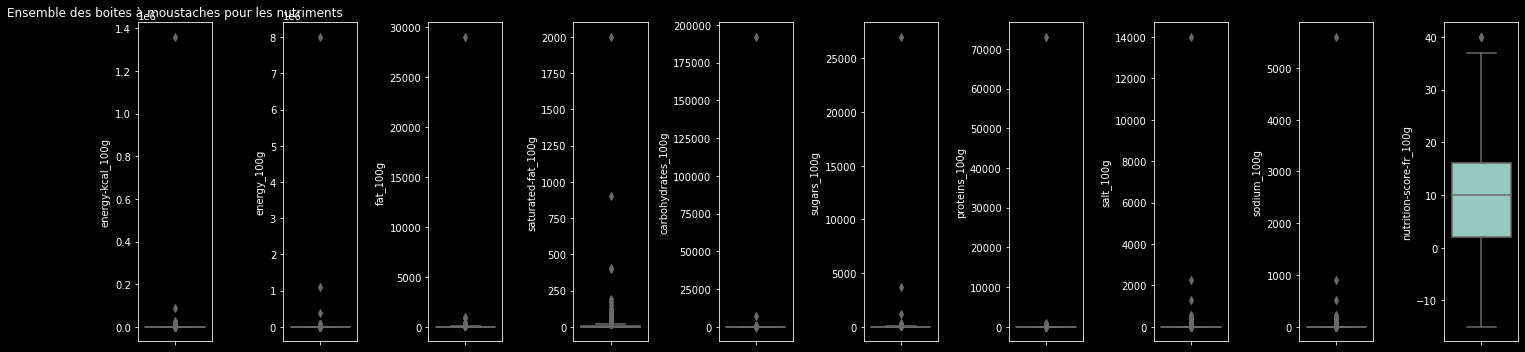

In [13]:
names = [col for col in df_french_data.columns if '_100g' in col]


fig, axes = plt.subplots(1,len(names), figsize=(20,5))

for i,t in enumerate(names):
    sns.boxplot(data=df_french_data, y=t, ax=axes[i % len(names)])

axes[0].set_title("Ensemble des boites à moustaches pour les nutriments")

plt.tight_layout()
plt.show()

<span style='color:#d95cdb'>Nous remarquons des outliers au vu de la valeur maximal des colonnes. Nous allons maintenant afficher notre Dataset avec les outliners.</span>

In [14]:
df_french_data.describe()

,created_t,last_modified_t,nutriscore_score,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,rows_empty
count,8.065820e+05,8.065820e+05,308726.000000,6.347630e+05,6.604690e+05,654608.000000,658417.000000,654559.000000,658043.000000,656431.000000,636427.000000,636426.000000,308729.000000,806582.000000
mean,1.542844e+09,1.590509e+09,9.433349,2.795625e+02,1.168862e+03,14.203988,5.388146,27.368156,13.672434,8.977551,1.281294,0.512614,9.433442,12.416084
std,5.205704e+07,3.446269e+07,8.765857,1.722879e+03,9.992743e+03,39.907085,8.417320,239.079803,39.101617,90.643984,18.411693,7.364860,8.765876,13.890795
min,1.328021e+09,1.333873e+09,-15.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,-15.000000,0.000000
25%,1.518694e+09,1.566585e+09,2.000000,1.110000e+02,4.610000e+02,1.000000,0.200000,2.500000,0.600000,1.500000,0.060000,0.024000,2.000000,0.000000
50%,1.540112e+09,1.597399e+09,10.000000,2.640000e+02,1.095000e+03,8.000000,2.000000,14.000000,3.400000,6.200000,0.520000,0.208000,10.000000,10.000000
75%,1.578938e+09,1.618073e+09,16.000000,4.010000e+02,1.674000e+03,22.000000,8.000000,52.000000,19.200000,13.000000,1.300000,0.520000,16.000000,16.666667
max,1.637108e+09,1.637113e+09,40.000000,1.360000e+06,8.010000e+06,29000.000000,2000.000000,192000.000000,27000.000000,73000.000000,14000.000000,5600.000000,40.000000,40.000000


In [15]:
list_col = [col for col in df_french_data.columns if '_100g' in col and col not in list_col_to_keep]


def outliers_iqr(df, col):
    q1=df[col].quantile(0.25)
    q3=df[col].quantile(0.75)
    iqr=q3-q1
    
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return df[(df[col] > lower_bound) & (df[col] < upper_bound)]

def outliers_aberantes(df, col):
    if col == 'energy_100g' or col == 'energy_kcal_100g':
        return df[(df[col] > 0) & (df[col] < 4000)]
    else:
        return df[(df[col] > 0) & (df[col] < 100)]

for col in list_col:
    df_french_data = outliers_aberantes(df_french_data, col)

for col in list_col:
    df_french_data = outliers_iqr(df_french_data, col)

df_french_data.describe()


,created_t,last_modified_t,nutriscore_score,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,rows_empty
count,4.539700e+04,4.539700e+04,23611.000000,45397.000000,45397.000000,45397.000000,4.539700e+04,45397.000000,4.539700e+04,45397.000000,4.539700e+04,4.539700e+04,23611.000000,45397.000000
mean,1.529149e+09,1.593285e+09,0.900428,55.046126,230.477565,1.538783,5.885239e-01,7.794606,5.406719e+00,2.165853,3.773521e-01,1.509408e-01,0.900428,5.257029
std,5.010932e+07,3.233470e+07,5.061774,25.164022,105.447897,1.343497,6.216411e-01,4.481177,4.447193e+00,1.739865,3.939734e-01,1.575892e-01,5.061774,5.407973
min,1.332261e+09,1.393194e+09,-14.000000,0.052000,0.400000,0.000001,1.000000e-08,0.000001,1.000000e-08,0.000001,5.500000e-08,2.200000e-08,-14.000000,0.000000
25%,1.510160e+09,1.570026e+09,-2.000000,37.000000,155.000000,0.500000,1.000000e-01,4.400000,1.500000e+00,0.700000,8.000000e-02,3.200000e-02,-2.000000,0.000000
50%,1.528023e+09,1.600527e+09,1.000000,54.000000,228.000000,1.100000,3.000000e-01,7.200000,4.300000e+00,1.600000,1.400000e-01,5.600000e-02,1.000000,6.666667
75%,1.555831e+09,1.619868e+09,3.000000,75.000000,314.000000,2.400000,1.000000e+00,11.300000,9.200000e+00,3.300000,6.900000e-01,2.760000e-01,3.000000,10.000000
max,1.637096e+09,1.637112e+09,29.000000,99.900000,517.000000,6.700000,2.340000e+00,21.700000,1.930000e+01,7.760000,1.630000e+00,6.520000e-01,29.000000,20.000000


In [16]:
df_french_data.shape

(45397, 31)

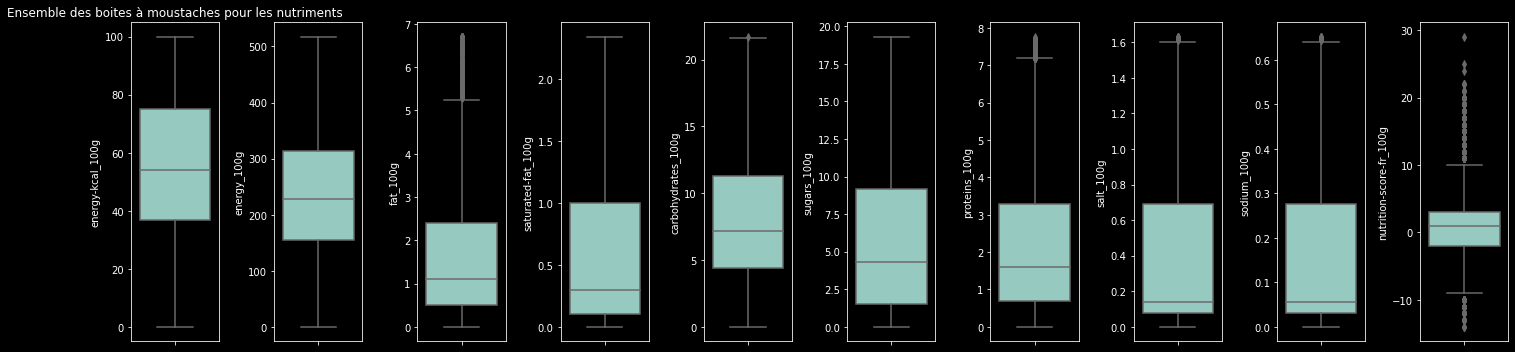

In [17]:
names = [col for col in df_french_data.columns if '_100g' in col]

fig, axes = plt.subplots(1,len(names), figsize=(20,5))

for i,t in enumerate(names):
    sns.boxplot(data=df_french_data, y=t, ax=axes[i % len(names)])

axes[0].set_title("Ensemble des boites à moustaches pour les nutriments")

plt.tight_layout()
plt.show()

<span style="color:#d95cdb">Maintenant que nous avons retiré tout les outliers, nous allons utiliser l'ACP et nous allons remplacer les valeurs manquantes.</span>

In [18]:
for col in df_french_data.columns:
    if df_french_data[col].dtype == 'float':
        df_french_data[col] = df_french_data[col].fillna(df_french_data[col].mean())
    elif df_french_data[col].dtype == 'str' or df_french_data[col].dtype == 'object':
        df_french_data[col] = df_french_data[col].fillna("Aucune valeur")
    
df_french_data.isna().sum()

code                       0
url                        0
creator                    0
created_t                  0
created_datetime           0
last_modified_t            0
last_modified_datetime     0
product_name               0
countries                  0
countries_tags             0
countries_en               0
nutriscore_score           0
nutriscore_grade           0
pnns_groups_1              0
pnns_groups_2              0
states                     0
states_tags                0
states_en                  0
image_url                  0
image_small_url            0
energy-kcal_100g           0
energy_100g                0
fat_100g                   0
saturated-fat_100g         0
carbohydrates_100g         0
sugars_100g                0
proteins_100g              0
salt_100g                  0
sodium_100g                0
nutrition-score-fr_100g    0
rows_empty                 0
dtype: int64

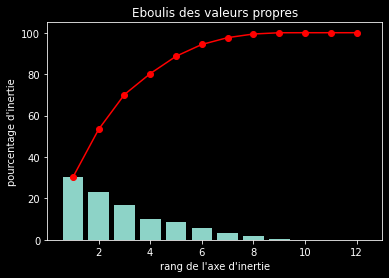

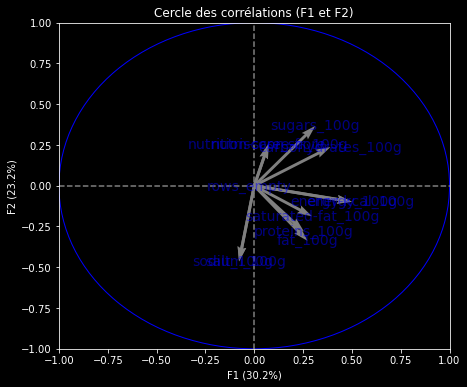

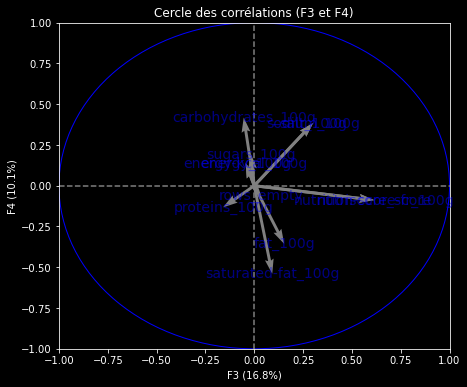

In [19]:
from functions import *
n_comp = 4

df_float = df_french_data.select_dtypes(include=['float'])

X = df_float.values
names = df_french_data["product_name"] 
features = df_float.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA()
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(features))

In [20]:
pca.transform(X_scaled)

array([[ 3.59613840e-01, -2.40861276e+00,  1.41872706e+00, ...,
        -5.18872598e-03,  1.24381992e-07,  1.30930936e-16],
       [-1.89678864e+00,  5.03958546e-01,  8.43554940e-02, ...,
         1.62747249e-03, -6.91782058e-07, -6.18036971e-17],
       [ 1.00545538e+00, -1.07512013e+00, -6.64283241e-01, ...,
         2.41537898e-03,  3.14650786e-07,  1.13682030e-16],
       ...,
       [ 1.18756840e+00,  2.59506666e+00, -7.67986818e-01, ...,
         1.81093454e-05, -4.31755345e-07, -1.28196537e-16],
       [ 6.59271251e-01,  8.73530263e-01, -2.75952076e+00, ...,
        -9.55152928e-04,  3.70681872e-06, -1.69710476e-16],
       [ 1.82006147e+00, -2.90756062e+00,  1.37029924e+00, ...,
         2.75698693e-03,  1.24546037e-06,  1.50022846e-16]])

In [21]:
pca_test = decomposition.PCA(0,80)
pca_test.fit(X_scaled)



C:\Users\utilisateur\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass copy=80 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


PCA(copy=80, n_components=0)

In [22]:
pca_test.explained_variance_

array([], dtype=float64)

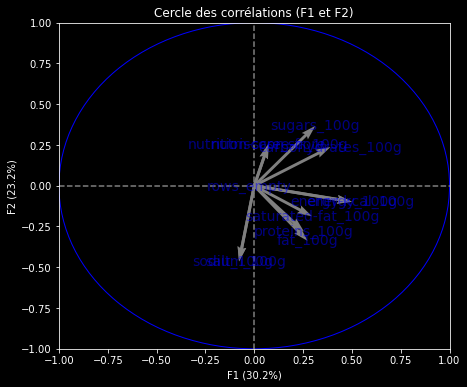

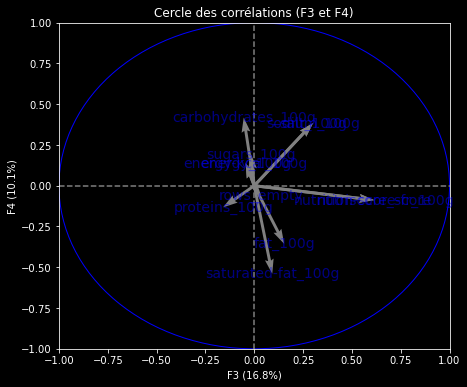

In [23]:
pca_four_cpt = decomposition.PCA(n_components=4)
pca_four_cpt.fit(X_scaled)

# Cercle des corrélations
pcs = pca_four_cpt.components_
display_circles(pcs, 4, pca, [(0,1),(2,3)], labels = np.array(features))

In [24]:
x_project = pca_four_cpt.transform(X_scaled)
pd.DataFrame(data=x_project, index=df_french_data.index)

,0,1,2,3
10,0.359614,-2.408613,1.418727,0.880037
18,-1.896789,0.503959,0.084355,0.431485
40,1.005455,-1.075120,-0.664283,-1.140581
90,1.067820,-0.295871,-0.811675,-0.291888
98,0.762224,-1.707366,0.290711,-2.345868
...,...,...,...,...
2028226,-0.900305,-0.012469,0.057728,0.663299
2028229,-1.326731,-0.609902,0.439425,0.067973
2028291,1.187568,2.595067,-0.767987,1.311604
2028324,0.659271,0.873530,-2.759521,1.354000


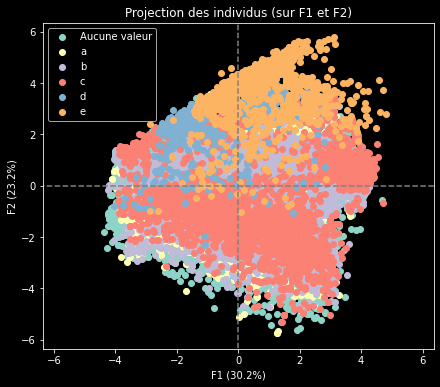

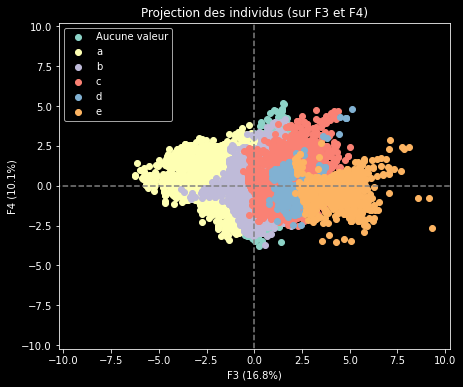

In [25]:
display_factorial_planes(x_project, 4, pca_four_cpt, [(0,1),(2,3)], illustrative_var=df_french_data['nutriscore_grade'])
plt.show()

<span style="color:#d95cdb">Nous allons maintenant retirer les colonnes peut utile pour notre projet.</span>

In [27]:
df_french_data.to_csv('data/nutri_score_french_clean.csv', sep='\t', index=False)

<span style="color:#d95cdb">Après le nettoyage complet de notre Dataframe, notre fichier contient maintenant 28 colonnes et 45397 lignes. Notre jeu de données était de 4.5 Go, après le nettoyage, il ne reste que 74 Mo.</span>